In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.animation as animation
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
device = torch.device('cpu')

G = nx.karate_club_graph()
pos = nx.spring_layout(G)
comm_dict = partition(G)
clusters_number = 5 #set the number of clusters required here

In [15]:
A_hat = nx.adjacency_matrix(G).todense()
X = np.identity(G.number_of_nodes(), dtype=np.float)   
#y = ground truth for karate network
y = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [16]:
class CDCGS(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden):
    super(CDCGS, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.A_hat = A_hat
    self.W_0 = nn.Parameter(torch.ones(num_feat, num_hidden))
    I = F.one_hot(torch.tensor(random.sample(range(0, num_feat), num_feat)), num_classes=num_feat)
    self.I = torch.tensor(I,dtype=torch.float)

  def forward(self, X, A_hat,temp):
    global featureSelector
    global weight_feature
    featureSelector = self.W_0
    results = torch.zeros(self.W_0.size())
    x = 500
    for i in range(x):
        results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
    weight_feature = results/x
    
    H = torch.mm(torch.mm(self.I,A_hat),self.I.T)
    H = torch.mm(torch.mm(weight_feature.T,A_hat),weight_feature)
    H = torch.div(H, H.sum(axis=0))
    m = nn.Softmax(dim=0)
    return m(H)

num_feat = len(G.nodes())
num_hidden = clusters_number

model = CDCGS(A_hat, num_feat, num_hidden).to(device)

def lossFn(output,exp): 
    return torch.sum((torch.diag(-torch.log(output))))

optimizer = optim.Adam(model.parameters(),lr=1e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)

A_hat_tensor = torch.Tensor(A_hat).to(device)
X_tensor = torch.Tensor(X).to(device)
y_tensor = torch.LongTensor(y).to(device)    

loss_hist = []
acc_hist = []
temp = 4
logits=[]
for epoch in range(600):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 2.5
    elif(epoch == 100):
        temp = 2
    elif(epoch == 150):
        temp = 1.5
    elif(epoch == 200):
        temp = 1
    elif(epoch == 300):
        temp = 0.5
    elif(epoch == 400):
        temp = 0.25
    elif(epoch == 500):
        temp = 0.1
    output = model(X_tensor, A_hat_tensor,temp)
    loss = lossFn(output,torch.diag(torch.ones(output.size()[0])))
    loss_hist.append(loss.item())
    print('loss',loss)
    loss.backward()
    optimizer.step()



<ipython-input-16-8dae06297575>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.I = torch.tensor(I,dtype=torch.float)


loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0472, grad_fn=<SumBackward0>)
loss tensor(8.0471, grad_fn=<SumBackward0>)
loss tensor(8.0471, grad_fn=<SumBackward0>)
loss tensor(8.0471, grad_fn=<SumBackward0>)
loss tensor(8.0470, grad_fn=<SumBackward0>)
loss tensor(8.0470, grad_fn=<SumBackward0>)
loss tensor(8.0470, grad_fn=<SumBackward0>)
loss tensor(8.0468, grad_fn=<SumBackward0>)
loss tensor(8.0465, grad_fn=<SumBackward0>)
loss tensor(8.0465, grad_fn=<SumBackward0>)
loss tensor(8.0463, grad_fn=<SumBackward0>)
loss tensor(8.0461, grad_fn=<SumBackward0>)
loss tensor(8.0461, grad_fn=<SumBackward0>)
loss tensor(8.0456, grad_fn=<SumBackward0>)
loss tensor(8.0455, grad_fn=<SumBackward0>)
loss tensor(8.0451, grad_fn=<Sum

loss tensor(7.1571, grad_fn=<SumBackward0>)
loss tensor(7.1496, grad_fn=<SumBackward0>)
loss tensor(7.1426, grad_fn=<SumBackward0>)
loss tensor(7.1365, grad_fn=<SumBackward0>)
loss tensor(7.1235, grad_fn=<SumBackward0>)
loss tensor(7.1207, grad_fn=<SumBackward0>)
loss tensor(7.1150, grad_fn=<SumBackward0>)
loss tensor(7.1042, grad_fn=<SumBackward0>)
loss tensor(7.1014, grad_fn=<SumBackward0>)
loss tensor(7.0939, grad_fn=<SumBackward0>)
loss tensor(7.0833, grad_fn=<SumBackward0>)
loss tensor(7.0814, grad_fn=<SumBackward0>)
loss tensor(7.0676, grad_fn=<SumBackward0>)
loss tensor(6.8805, grad_fn=<SumBackward0>)
loss tensor(6.8801, grad_fn=<SumBackward0>)
loss tensor(6.8626, grad_fn=<SumBackward0>)
loss tensor(6.8714, grad_fn=<SumBackward0>)
loss tensor(6.8502, grad_fn=<SumBackward0>)
loss tensor(6.8498, grad_fn=<SumBackward0>)
loss tensor(6.8423, grad_fn=<SumBackward0>)
loss tensor(6.8294, grad_fn=<SumBackward0>)
loss tensor(6.8250, grad_fn=<SumBackward0>)
loss tensor(6.8172, grad_fn=<Sum

loss tensor(6.2359, grad_fn=<SumBackward0>)
loss tensor(6.2278, grad_fn=<SumBackward0>)
loss tensor(6.2295, grad_fn=<SumBackward0>)
loss tensor(6.2331, grad_fn=<SumBackward0>)
loss tensor(6.2295, grad_fn=<SumBackward0>)
loss tensor(6.2314, grad_fn=<SumBackward0>)
loss tensor(6.2271, grad_fn=<SumBackward0>)
loss tensor(6.2331, grad_fn=<SumBackward0>)
loss tensor(6.2308, grad_fn=<SumBackward0>)
loss tensor(6.2256, grad_fn=<SumBackward0>)
loss tensor(6.2293, grad_fn=<SumBackward0>)
loss tensor(6.2262, grad_fn=<SumBackward0>)
loss tensor(6.2259, grad_fn=<SumBackward0>)
loss tensor(6.2284, grad_fn=<SumBackward0>)
loss tensor(6.2263, grad_fn=<SumBackward0>)
loss tensor(6.2258, grad_fn=<SumBackward0>)
loss tensor(6.2270, grad_fn=<SumBackward0>)
loss tensor(6.2284, grad_fn=<SumBackward0>)
loss tensor(6.2226, grad_fn=<SumBackward0>)
loss tensor(6.2288, grad_fn=<SumBackward0>)
loss tensor(6.2293, grad_fn=<SumBackward0>)
loss tensor(6.2281, grad_fn=<SumBackward0>)
loss tensor(6.2274, grad_fn=<Sum

loss tensor(6.2038, grad_fn=<SumBackward0>)
loss tensor(6.2103, grad_fn=<SumBackward0>)
loss tensor(6.2102, grad_fn=<SumBackward0>)
loss tensor(6.2089, grad_fn=<SumBackward0>)
loss tensor(6.2102, grad_fn=<SumBackward0>)
loss tensor(6.2071, grad_fn=<SumBackward0>)
loss tensor(6.2120, grad_fn=<SumBackward0>)
loss tensor(6.2101, grad_fn=<SumBackward0>)
loss tensor(6.2116, grad_fn=<SumBackward0>)
loss tensor(6.2088, grad_fn=<SumBackward0>)
loss tensor(6.2083, grad_fn=<SumBackward0>)
loss tensor(6.2084, grad_fn=<SumBackward0>)
loss tensor(6.2098, grad_fn=<SumBackward0>)
loss tensor(6.2104, grad_fn=<SumBackward0>)
loss tensor(6.2083, grad_fn=<SumBackward0>)
loss tensor(6.2100, grad_fn=<SumBackward0>)
loss tensor(6.2103, grad_fn=<SumBackward0>)
loss tensor(6.2056, grad_fn=<SumBackward0>)
loss tensor(6.2074, grad_fn=<SumBackward0>)
loss tensor(6.2075, grad_fn=<SumBackward0>)
loss tensor(6.2107, grad_fn=<SumBackward0>)
loss tensor(6.2103, grad_fn=<SumBackward0>)
loss tensor(6.2096, grad_fn=<Sum

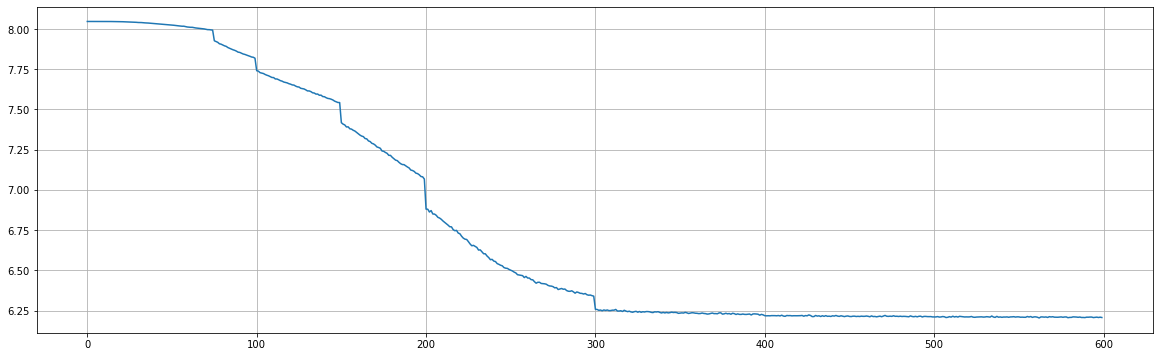

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(loss_hist)
plt.grid(True)
plt.show()

In [18]:
gumbel_matrix = weight_feature.detach().max(dim=1)[1]
labels_true = y
labels_pred = gumbel_matrix.data.numpy()

print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))
print('Modularity of such partition for karate is %.3f' %get_modularity(G, labels_pred))

adjusted_rand_score 0.35093366426867817
normalized_mutual_info_score 0.5372750271451968
homogeneity_score 0.8850029611132764
completeness_score 0.385720834817184
v_measure_score 0.5372750271451967
Calculating modularity for undirected graph
Modularity of such partition for karate is 0.368


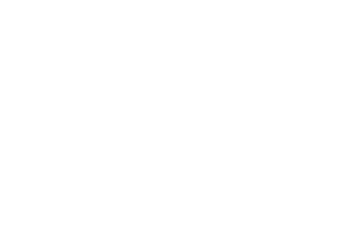

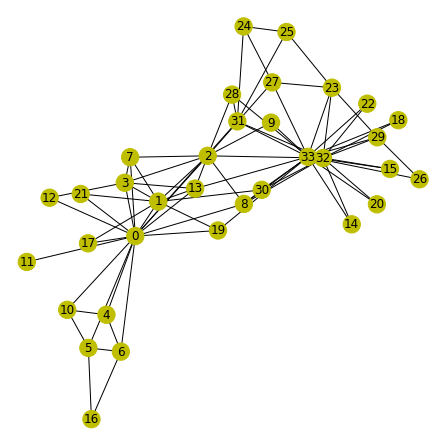

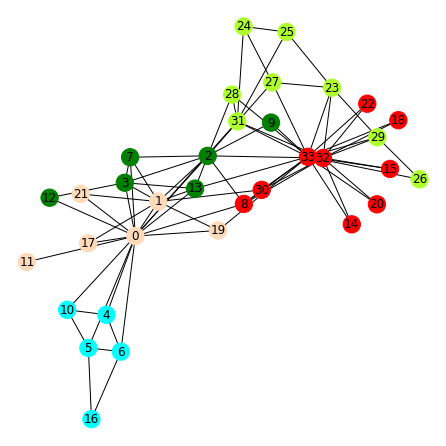

In [19]:
import numpy as np

import matplotlib.pyplot as plt
pos = nx.spring_layout(G)

color = []
for node in G.nodes:
    if G.nodes[node]['club'] == 'Mr. Hi':
        color.append('y')
    elif G.nodes[node]['club'] == 'Officer':
        color.append('y')

plt.axis('off')
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos, node_size=300, node_color=color, with_labels=True)


color = []
for c in range(34):
    if(gumbel_matrix[c] == 0):
        color.append('r')
    elif(gumbel_matrix[c] == 1):
        color.append('g')
    elif(gumbel_matrix[c] == 2):
        color.append('peachpuff')
    elif(gumbel_matrix[c] == 3):
        color.append('greenyellow')
    elif(gumbel_matrix[c] == 4):
        color.append('aqua')
    elif(gumbel_matrix[c] == 5):
        color.append('lightcyan')
    elif(gumbel_matrix[c] == 6):
        color.append('thistle')
    elif(gumbel_matrix[c] == 7):
        color.append('gold')
    elif(gumbel_matrix[c] == 8):
        color.append('m')

#plt.subplot(212)
plt.axis('off')
plt.figure(figsize=(6, 6))
nx.draw(G, pos=pos, node_size=300, node_color=color, with_labels=True)
plt.show()